# Quick 15 minute (ish) PyTorch Demo

By Joshua Mitchell

https://lelon.io

jlelonmitchell@gmail.com

https://www.linkedin.com/in/joshua-mitchell-17b94077/

## Some quick Jupyter Notebooks features

In [1]:
# Install a conda package in the current Jupyter kernel

# import sys
# !conda install --yes --prefix {sys.prefix} <package name>

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # makes jupyter's auto-print functionality work for everything in cell

In [3]:
%load_ext autoreload
%autoreload 2

# e.g. : 

# from foo import some_function

# In [1]: some_function()
# Out[1]: 42

# In [2]: # open foo.py in an editor and change some_function to return 43

# In [3]: some_function()
# Out[3]: 43

In [4]:
# make any plots you create with matplotlib be displayed here in your jupyter notebook
%matplotlib inline

In [5]:
%autosave 30

Autosaving every 30 seconds


In [6]:
# Command palette (for those who think clicking is cumbersome, like me):
# CMD + Shift + P (might be CTRL + Shift + P or something on Windows)

#### Esc     -   command mode (navigation)
#### Enter  -   edit mode (typing)

#### D + D (press twice) to delete current cell

#### Shift + Tab   -   brings up the docstring for the object to the left of your cursor

#### Esc + O   -  toggle cell output

#### J, K   -   move up and down with vim commands

#### l (in command mode)    -   show line numbers

## Anyhow, back to PyTorch...

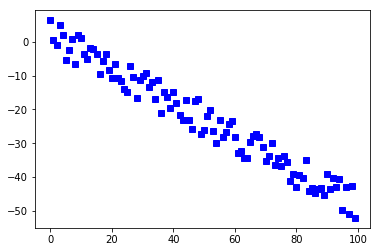

In [7]:
# Let's make some random data

import matplotlib.pyplot as plt
import numpy as np

NUM_DATA_POINTS = 100

x = np.arange(NUM_DATA_POINTS) # create a an array: [0, 1, 2... NUM_DATA_POINTS]
noise = np.random.uniform(-5,5, size=(NUM_DATA_POINTS,)) # create some noise to add to a truly straight line
y = -0.5 * x + 2 + noise # create a straight line plus some noise

axes = plt.gca()
line, = axes.plot(list(x), list(y), 'bs')

## Awesome, we have some data. Looks like fair game for a linear regression model.

In [8]:
# Data setup:

test_data_amount     = int(0.2 * NUM_DATA_POINTS)
training_data_amount = NUM_DATA_POINTS - test_data_amount

all_data_indices = [i for i in range(NUM_DATA_POINTS)]

x_test  = np.random.choice(all_data_indices, test_data_amount, replace=False)
# get the indices of 20% of the data for testing

x_train = list(set(all_data_indices).difference(set(x_test)))
# get the indices of the rest for training

y_test  = [y[i] for i in x_test]
y_train = [y[i] for i in x_train]

# Enter: PyTorch

import torch
from torch.autograd import Variable

x_train = torch.Tensor(x_train)
# an n-dimensional array : array (1d) --> matrix (2d) --> tensor (3d) --> tensor (4d) ...)

x_train_var = Variable(x_train) 
# wraps the tensor in a Variable class to add extra features we'll see later

x_test = torch.Tensor(x_test)
x_test_var = Variable(x_test)

# Let's check out our variables:

x_test_var
len(x_test_var)

x_train_var
len(x_train_var)

tensor([91.,  5., 28., 23., 14., 57., 73., 90., 60., 59., 19., 81., 20., 87.,
        47., 42., 21., 96., 86., 29.])

20

tensor([ 0.,  1.,  2.,  3.,  4.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 15.,
        16., 17., 18., 22., 24., 25., 26., 27., 30., 31., 32., 33., 34., 35.,
        36., 37., 38., 39., 40., 41., 43., 44., 45., 46., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 58., 61., 62., 63., 64., 65., 66., 67., 68.,
        69., 70., 71., 72., 74., 75., 76., 77., 78., 79., 80., 82., 83., 84.,
        85., 88., 89., 92., 93., 94., 95., 97., 98., 99.])

80

## Sweet. Now let's actually make the linear model.

#### Quick linear regression review:

The line we're creating is:

y = mx + b

We have the data (the x's and the y's).

We want to know what the m and b are such that the line fits the data the best.

For now, let's just make an arbitrary line with PyTorch:

In [9]:
import torch.nn as nn ## Neural Network package

line_model = nn.Linear(1, 1) # create a line with 1 slope (i.e. weight) and one intercept (i.e. bias)

# Done! We made a line. What's it look like?

line_model

Linear(in_features=1, out_features=1, bias=True)

#### Notice: we're barely using any of the features here. 

We can actually make it with as many weights and as many outputs as we want. We'll do that later.

Speaking of weights, how do we find out what the m and b actually are?

In [10]:
list(line_model.parameters())

[Parameter containing:
 tensor([[-0.3560]], requires_grad=True), Parameter containing:
 tensor([0.5625], requires_grad=True)]

Note: These are randomly generated.

#### How do we make the line fit the data?

In [11]:
test_input = Variable(torch.Tensor(x_test_var))
line_model(test_input)

RuntimeError: size mismatch, m1: [1 x 20], m2: [1 x 1] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070

## Tensors are tricky. What's going on here?

### What we wanted to do:

- Take the x values of our test data (which was literally the indices)
- Run all those values through our line, one at a time (i.e. put an x in, get a y)
- See the results

### What PyTorch thinks we want to do:

- Take all the x values of our test data
- Fit all the x's into the line at once, as though our line had 20 inputs

Our line only has one input. So what's the solution?

### Answer:

Reshape our tensor.

In [12]:
test_input = Variable(torch.Tensor(x_test_var))
"BEFORE"
test_input
"AFTER"
test_input.view(-1, 1)

'BEFORE'

tensor([91.,  5., 28., 23., 14., 57., 73., 90., 60., 59., 19., 81., 20., 87.,
        47., 42., 21., 96., 86., 29.])

'AFTER'

tensor([[91.],
        [ 5.],
        [28.],
        [23.],
        [14.],
        [57.],
        [73.],
        [90.],
        [60.],
        [59.],
        [19.],
        [81.],
        [20.],
        [87.],
        [47.],
        [42.],
        [21.],
        [96.],
        [86.],
        [29.]])

In [13]:
line_model(test_input.view(-1, 1)) 

tensor([[-31.8363],
        [ -1.2177],
        [ -9.4064],
        [ -7.6262],
        [ -4.4219],
        [-19.7312],
        [-25.4277],
        [-31.4802],
        [-20.7993],
        [-20.4433],
        [ -6.2021],
        [-28.2760],
        [ -6.5581],
        [-30.4121],
        [-16.1709],
        [-14.3908],
        [ -6.9141],
        [-33.6164],
        [-30.0561],
        [ -9.7624]], grad_fn=<ThAddmmBackward>)

It works!

## Ugh, making lines is hard.

What are we doing again?

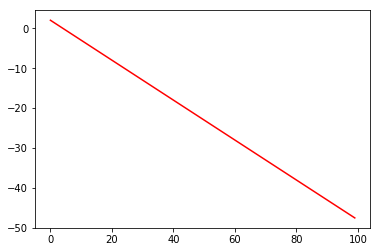

In [14]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
plt.show()

### Above: The line we're trying to recreate.

### Below: The data we're using to recreate the line above.

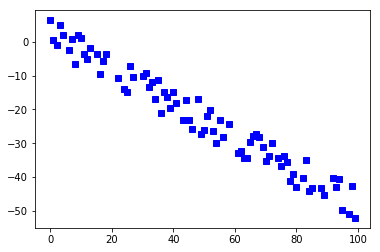

In [15]:
axes = plt.gca()
line, = axes.plot(list(x_train), list(y_train), 'bs')
plt.show()

### Our line currently:

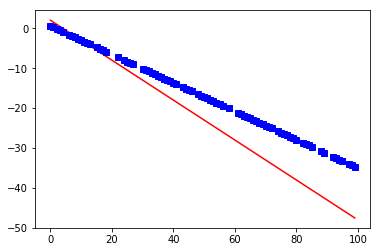

In [16]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
line, = axes.plot(list(x_train), list(line_model(x_train.view(-1, 1))), 'bs')
plt.show()

### Okay, so we're a little off. How do we fix it?

### Answer: Some kind of optimization on a loss function.

In [17]:
# Now, let's bring in all the big guns from PyTorch.
# Fair warning, there's a lot of machine learning / deep learning vocabulary here. Can get kitchen sink-ey.

import torch.optim as optim # Optimization package

NUMBER_OF_EPOCHS = 30000       # Number of times to adjust our model
LEARNING_RATE = 1e-2           # How quickly our model "learns"
loss_function = nn.MSELoss()   # The loss function we use. In this case, Mean Squared Error (since it's Linear Regression)
optimizer = optim.Adagrad(line_model.parameters(), lr=LEARNING_RATE) # The optimizer: Stochastic Gradient Descent

y_train_var = Variable(torch.Tensor(y_train)).view(-1, 1) # making our labels into a form usable by PyTorch

for epoch in range(NUMBER_OF_EPOCHS):
    line_model.zero_grad()
    output = line_model(x_train_var.view(-1, 1)) # get our output from the model
    loss = loss_function(output, y_train_var)    # calculate the loss
    loss.backward()                              # calculate all the partial derivatives wrt to the loss function
    optimizer.step()                             # add or subtract a portion of the derivatives from each weight / bias



In [18]:
list(line_model.parameters()) # should be -0.5 and 2 (ish)

[Parameter containing:
 tensor([[-0.5119]], requires_grad=True), Parameter containing:
 tensor([2.4408], requires_grad=True)]

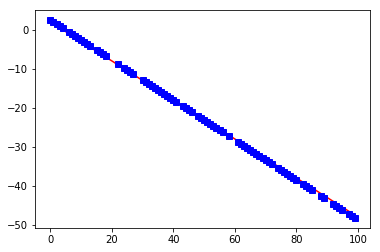

In [19]:
axes = plt.gca()
line, = axes.plot(list(x_train), [-0.5 * x + 2 for x in list(x_train)], 'r-')
line, = axes.plot(list(x_train), list(line_model(x_train.view(-1, 1))), 'bs')
plt.show()

## Yeah, yeah, yeah, enough with the lines, I came here for the neural networks!

Ok fine. Here's a demo for that:

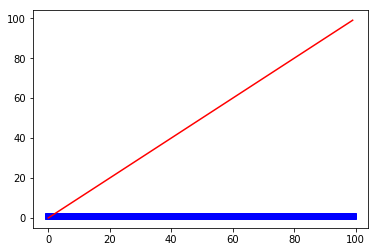

In [20]:
x_train = Variable(torch.Tensor([[i] for i in range(100)]), requires_grad=False)
y_train = Variable(torch.Tensor([[i] for i in range(100)]), requires_grad=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

net = Net() # we made a blueprint above for our neural network, now we initialize one.

axes = plt.gca()
line, = axes.plot(list(x_train), list(net(x_train)), 'bs')
line, = axes.plot(list(x_train), list(x_train), 'r-')
plt.show()

# Red: The identity function: y = x (we're trying to approximate it)
# Blue: What our neural network does now

In [ ]:
%matplotlib inline

NUMBER_OF_EPOCHS = 10000
LEARNING_RATE = 0.1
loss_function = nn.MSELoss()
optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE) 

import pylab as pl
from IPython import display

for epoch in range(NUMBER_OF_EPOCHS):
    net.zero_grad()
    output = net(x_train)
    loss = loss_function(output, y_train)
    loss.backward()
    optimizer.step()
    
    display.clear_output(wait=True)
    axes = plt.gca()
    line, = axes.plot(list(x_train), list(net(x_train)), 'bs')
    line, = axes.plot(list(x_train), list(x_train), 'r-')
    plt.show()